In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [2]:
#Tensorboard Things

%load_ext tensorboard
import tensorflow as tf
import datetime, os


In [3]:
### MODELS
import numpy as np
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.applications import ResNet50, VGG16
from keras.models import Model, Sequential


"""
Create a new feature extractor based on the pretrained VGG16 model:
The model is frozen from the bottom layer up to block4 conv layer 2. 
Conv layer 3 from block 4 is then pooled with GlobalMaxPool2D, and
connected to a Dense layer with 1024 neurons, and then to the softmax layer.
"""
def VGG(seed = None):
    np.random.seed(seed)
    vgg16 = VGG16(weights="imagenet", include_top=False)
    for layer in vgg16.layers[:13]:
        layer.trainable = False
    for layer in vgg16.layers[13:]:
        layer.trainable = True
    y = (vgg16.get_layer("block4_conv3")).output
    mx_y = GlobalMaxPool2D()(y)
    x = BatchNormalization()(mx_y)
    x = Dropout(.5)(x)
    x = Dense(1024, activation='relu', name="dense_1024")(x)
    x = BatchNormalization()(x)
    x = Dropout(.5)(x)
    preds = Dense(2,activation='softmax')(x)
    model = Model(inputs=vgg16.input, outputs=preds)
    return model

In [5]:
import numpy as np
from keras.layers import Dense, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



"""LOAD DATA"""
# path to folder with data
path = "C:/Users/RCUB-CS/signature2/"
# specify image data generator with data augmentation (train_datagen) resp. without (no_DA_IDG)
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   rotation_range = 5, fill_mode="nearest",
                                   zoom_range=[1/1.0, 1/1.0], width_shift_range=0.0, height_shift_range=0.0,
                                   horizontal_flip = True, vertical_flip=True,
                                   brightness_range=[0.5, 1.3], channel_shift_range=20)

no_DA_IDG = ImageDataGenerator()

# in training set: use data augmentation image data generator, for validation and test: no data augmentation.
training_set = train_datagen.flow_from_directory(path+"train/",
                                                target_size=(224, 224), # typical imagenet dimensions
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical', shuffle=True)



validation_set =  no_DA_IDG.flow_from_directory(path+"val/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                shuffle=True)



test_set_V2 = no_DA_IDG.flow_from_directory(path+"test/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)

Found 2457 images belonging to 2 classes.
Found 702 images belonging to 2 classes.
Found 351 images belonging to 2 classes.


In [6]:
###############################################################################################
"""CREATE & TRAIN MODELS"""

model_vgg = VGG()

""" The model was trained with a Adam with a learning rate of 1e-3 for 50 epochs.
Then the training was continued for 50 epochs at a lower learning rate.
The weights loaded at the end of the block result from a good run (based on validation score) following the described
training regime.
"""

epochs = 5
opt = Adam(learning_rate=1e-3)
model_vgg.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model_vgg.fit_generator(generator=training_set, epochs=epochs, validation_data=validation_set, verbose=2)

#opt = Adam(learning_rate=1e-4)
#model_vgg.fit_generator(generator=training_set, epochs=epochs, validation_data=validation_set, verbose=2)

# save model weights
model_vgg.save_weights("SagarSignVGG16weights.h5")

"""EVALUATE PERFORMANCE ON THE TEST SET"""

y_test = test_set_V2.classes
pred = np.argmax(model_vgg.predict_generator(test_set_V2, steps = test_set_V2.n), axis=1)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Epoch 1/5
77/77 - 388s - loss: 0.8493 - acc: 0.6479 - val_loss: 0.8040 - val_acc: 0.7222 - 388s/epoch - 5s/step
Epoch 2/5
77/77 - 391s - loss: 0.6987 - acc: 0.6960 - val_loss: 0.6653 - val_acc: 0.7493 - 391s/epoch - 5s/step
Epoch 3/5
77/77 - 387s - loss: 0.6386 - acc: 0.7171 - val_loss: 0.6740 - val_acc: 0.7322 - 387s/epoch - 5s/step
Epoch 4/5
77/77 - 388s - loss: 0.5478 - acc: 0.7648 - val_loss: 0.6407 - val_acc: 0.7123 - 388s/epoch - 5s/step
Epoch 5/5
77/77 - 386s - loss: 0.5145 - acc: 0.7733 - val_loss: 0.4757 - val_acc: 0.8034 - 386s/epoch - 5s/step
0.8262108262108262
[[101  57]
 [  4 189]]
              precision    recall  f1-score   support

           0       0.96      0.64      0.77       158
           1       0.77      0.98      0.86       193

    accuracy                           0.83       351
   macro avg       0.87      0.81      0.81       351
weighted avg       0.86      0.83      0.82       351



In [7]:
model_vgg.save("SagarSignVGG16model.h5")

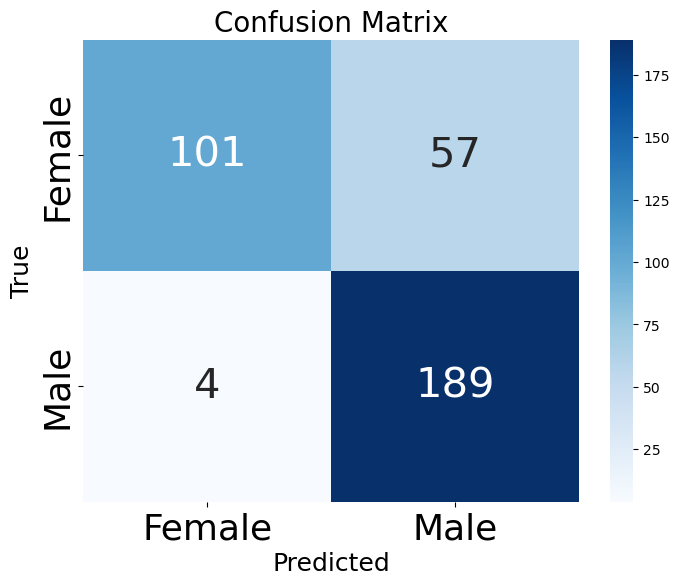

0.8262108262108262
              precision    recall  f1-score   support

           0       0.96      0.64      0.77       158
           1       0.77      0.98      0.86       193

    accuracy                           0.83       351
   macro avg       0.87      0.81      0.81       351
weighted avg       0.86      0.83      0.82       351



In [8]:
# Assuming pred and y_test are defined as in your code
cm = confusion_matrix(y_test, pred)

# Generate class labels
#labels = ['Female', 'Male']

# Plotting Confusion Matrix as a Heatmap with Custom Colormap and Label Font Size
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'],
                      annot_kws={"size": 30})  # Adjust font size for annotations here

# Adjust font size for x-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=26)
heatmap.set_yticklabels(heatmap.get_xticklabels(), fontsize=26)

plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix', fontsize=20)
plt.show()
# Printing additional metrics
print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred))